# Crack using CNN

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# Pytorch
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.backends import cudnn

from model import UNet

In [5]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

## Initial exploration

In [6]:
TRAIN_PATH = './Denoising/train/crack/'
TEST_PATH = './Denoising/test/crack/'
SEGMENTATION = './Denoising/train/cleaned/'
TRAIN_MASK_PATH = './Denoising/test/masked/'

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

In [12]:
# OpenCV python interface cv2
import cv2

row_sz = []
col_sz = []
for im_name in trainFiles_path_list:
    img = cv2.imread(TRAIN_PATH + im_name)
    row_sz.append(img.shape[0])
    col_sz.append(img.shape[1])

In [13]:
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)

In [15]:
labels = {}
for fname in trainFiles_path_list:
    labels[fname] = fname.split('.')[0] + '_cleaned.png'

In [16]:
masked = {}
for fname in testFiles_path_list:
    masked[fname] = fname.split('.')[0] + '_GT.png'

In [17]:
# Getting an insight of image size

(array([21., 21., 14.,  8.,  4.,  1.,  1.,  2.,  0.,  3.]),
 array([ 495. ,  704.7,  914.4, 1124.1, 1333.8, 1543.5, 1753.2, 1962.9,
        2172.6, 2382.3, 2592. ]),
 <a list of 10 Patch objects>)

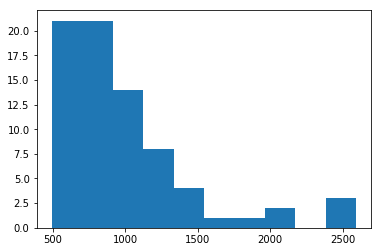

In [18]:
# colomn size distribution

plt.hist(row_sz)

(array([ 2., 12., 18.,  5.,  6.,  8.,  6.,  5.,  2.,  2.]),
 array([ 495. ,  586.9,  678.8,  770.7,  862.6,  954.5, 1046.4, 1138.3,
        1230.2, 1322.1, 1414. ]),
 <a list of 10 Patch objects>)

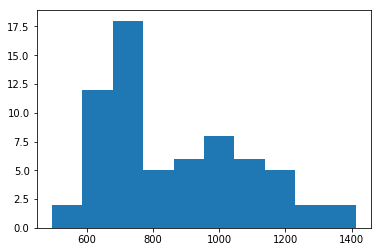

In [19]:
# Zoom on size < 1500

plt.hist(row_sz[row_sz < 1500])

(array([17., 29., 12.,  9.,  4.,  1.,  1.,  0.,  0.,  2.]),
 array([ 600. ,  927.2, 1254.4, 1581.6, 1908.8, 2236. , 2563.2, 2890.4,
        3217.6, 3544.8, 3872. ]),
 <a list of 10 Patch objects>)

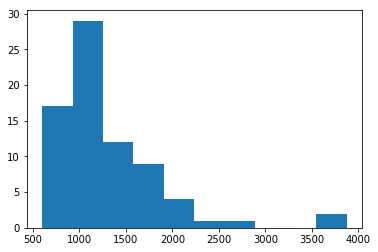

In [20]:
# colomn size distribution

plt.hist(col_sz)

(array([ 8.,  7., 15., 13.,  3., 10.,  2.,  8.,  1.,  1.]),
 array([ 600. ,  734.4,  868.8, 1003.2, 1137.6, 1272. , 1406.4, 1540.8,
        1675.2, 1809.6, 1944. ]),
 <a list of 10 Patch objects>)

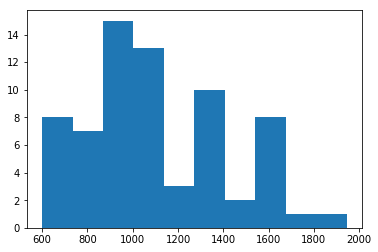

In [21]:
# Zoom on size < 2000

plt.hist(col_sz[col_sz < 2000])

In [22]:
# We can consider to resize to 800 in heigth and 1000 in width without degrading to much the picture
# For the moment we are choosing a size of 600x600 due to memory limitations

In [23]:
sz = (600, 600)

## Initial model

In [26]:
# DataLoader

import torch
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        
        X = cv2.resize(cv2.imread(TRAIN_PATH + ID, cv2.IMREAD_GRAYSCALE), sz)
        X = np.expand_dims(X, axis=0)
        X = torch.from_numpy(X)
        
        y = cv2.resize(cv2.imread(SEGMENTATION + self.labels[ID], cv2.IMREAD_GRAYSCALE), sz)
        y = np.expand_dims(y, axis=0)
        y = torch.from_numpy(y)

        return X, y

In [27]:
# Setting up the generator

# params = {'batch_size': 3,
#           'shuffle': True,
#           'num_workers': 12}

# Uncomment if the notebook is run on windows
params = {'batch_size': 3,
          'shuffle': True,
          'num_workers': 0}

training_set = Dataset(partition['train'], labels)
training_generator = data.DataLoader(training_set, **params)

validation_set = Dataset(partition['validation'], labels)
validation_generator = data.DataLoader(validation_set, **params)

## Training

In [2]:
# Training on Grayscale image

import time

start = time.time()
score = []
max_epochs = 600
model = UNet(1, 1).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output = model((local_batch.float()/255))
        loss = F.mse_loss(output, (local_labels.float()/255))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in validation_generator:
                # Transfer to GPU
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                output = model((local_batch.float()/255))
                score.append(F.mse_loss(output, (local_labels.float()/255)))
        model.train()
    print("\nEpoch {} \tAverage loss: {}".format(epoch + 1, np.mean(score)))
    
    # Save model every 50 epochs
    if (epoch + 1) % 50 == 0:
        PATH = "./model_5/checkpoint_{}.pth".format(epoch+1)
        torch.save(model.state_dict(), PATH)

end = time.time()
print(end-start)

Epoch 1 	Average loss: 0.03623107820749283

Epoch 50 	Average loss: 0.004056459292769432

Epoch 100 	Average loss: 0.0033878725953400135

Epoch 150 	Average loss: 0.003090395126491785

Epoch 200 	Average loss: 0.0029050935991108418

Epoch 250 	Average loss: 0.002823435701429844

Epoch 300 	Average loss: 0.0027590577956289053

Epoch 350 	Average loss: 0.002718551317229867

Epoch 400 	Average loss: 0.002678843215107918

Epoch 450 	Average loss: 0.0026468904688954353

Epoch 500 	Average loss: 0.0026138287503272295

Epoch 550 	Average loss: 0.002587314695119858

Epoch 600 	Average loss: 0.0025665860157459974

Elapsed time: 04h-52m-37s seconds

Epoch is number of complete passes through the training image. It is a hyperparameter that defines the number of times that the learning algorithm will work through the entire training dataset.

Average loss is the average of the loss of batches in that epoch.

In [ ]:
# Training on RGB image

import time

start = time.time()
score = []
max_epochs = 600
model = UNet(3, 3).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

for epoch in range(max_epochs):
    # Training
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        output = model((local_batch.float()/255).permute(0,3,1,2))
        loss = F.mse_loss(output, (local_labels.float()/255).permute(0,3,1,2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluation
        model.eval()
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in validation_generator:
                # Transfer to GPU
                local_batch, local_labels = local_batch.to(device), local_labels.to(device)
                output = model((local_batch.float()/255).permute(0,3,1,2))
                score.append(F.mse_loss(output, (local_labels.float()/255).permute(0,3,1,2)))
        model.train()
    print("\nEpoch {} \tAverage loss: {}".format(epoch + 1, np.mean(score)))
    
    # Save model every 50 epochs
    if (epoch + 1) % 50 == 0:
        PATH = "./model_5/checkpoint_{}.pth".format(epoch+1)
        torch.save(model.state_dict(), PATH)

end = time.time()
print(end-start)

Epoch 1 	Average loss: 0.04655402526259422

Epoch 50 	Average loss: 0.0064216977916657925

Epoch 100 	Average loss: 0.004951159469783306

Epoch 150 	Average loss: 0.004357353784143925

Epoch 200 	Average loss: 0.003998121712356806

Epoch 250 	Average loss: 0.00377761316485703

Epoch 300 	Average loss: 0.0035975740756839514

Epoch 350 	Average loss: 0.003458737162873149

Epoch 400 	Average loss: 0.0033507065381854773

Epoch 450 	Average loss: 0.0032665219623595476

Epoch 500 	Average loss: 0.00319574773311615

Epoch 550 	Average loss: 0.0031365426257252693

Epoch 600 	Average loss: 0.003080792259424925

Elapsed time: 05h-08m-55s seconds

## Inference & Benchmark

In [28]:
# Saved model loader

class modelLoader():
    def __init__(self, model_folder, in_chnl, out_chnl, checkpoint=None):
        self.checkpoint = checkpoint
        self.model_folder = model_folder
        self.in_chnl = in_chnl
        self.out_chnl = out_chnl
        self.model = None
    def set_model(self):
        self.model = UNet(self.in_chnl, self.out_chnl).to(device)
        PATH = "./{}/checkpoint_{}.pth".format(self.model_folder, self.checkpoint)
        self.model.load_state_dict(torch.load(PATH))
        self.model.eval()
        
    def model_infos(self):
        print("Checkpoint: {}, Model folder: ./{}, Input channel: {}, Output channel: {}".format(self.checkpoint,self.model_folder,self.in_chnl,self.out_chnl))

In [29]:
# Inference function

def detection_RGB(model, path, threshold):
    """Inference on an input RGB image
    Input:
        -model: model loaded
        -path: path of the input image
        -thresold: set a thresold to get rid of the noise
    Output:
        -result: inference on the input image as a numpy array
    """
    img2 = cv2.resize(cv2.imread(path), sz)
    test = model((torch.from_numpy(np.expand_dims(img2, axis=0)).float()/255).permute(0,3,1,2).to(device))
    test = (test.permute(0,2,3,1).cpu().data.detach().numpy()[0]*255).astype(int)
    diff = np.clip(test - img2, 0, 255)
    result = (diff > threshold) * diff
    return result

def detection_grayscale(model, path, threshold):
    """Inference on an input grayscale image
    Input:
        -model: model loaded
        -path: path of the input image
        -thresold: set a thresold to get rid of the noise
    Output:
        -result: inference on the input image as a numpy array
    """
    img2 = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), sz)
    test = model((torch.from_numpy(np.expand_dims(np.expand_dims(img2, axis=0), axis=0)).float()/255).to(device))
    test = np.squeeze((test.cpu().data.detach().numpy()[0]*255).astype(int), axis=0)
    diff = np.clip(test - img2, 0, 255)
    result = (diff > threshold) * diff
    return result

In [30]:
model_GrayScale = modelLoader("model_GrayScale", 1, 1)
model_RGB = modelLoader("model_RGB", 3, 3)

### Dice score  

Dice score is a performance metric for image segmentation problems 

In [33]:
def dice(pred, targs):
    pred = (pred > 0) * pred
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

Image classification using RGB and Grayscale model and Ground truth for accuracy of the training image classification with the model.

<--- GRAYSCALE & RGB DICE SCORE COMPARISON --->



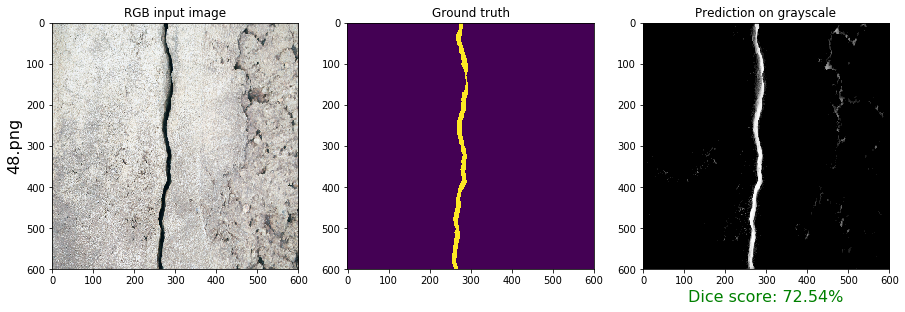

In [34]:
# Choose a test file in range [0,...,49]

test_file = 42

fname = testFiles_path_list[test_file]

# Change checkpoint value to see evolution in prediction
# Checkpoint to load among 50, 100, 150, 200, 250, 300, 350, 450, 500, 550, 600

checkpoint = 350

# Thresold to choose in range [0,...,255] to get rid of part the noise in prediction image

threshold = 15

# model_GrayScale is trained on grayscaled image (1 channel)

model_GrayScale.checkpoint = checkpoint
model_GrayScale.set_model()

# model_RGB is trained on RGB image (3 channels)
    
model_RGB.checkpoint = checkpoint
model_RGB.set_model()

plt.subplot(1, 3, 1)
plt.ylabel(fname, fontsize=16)
plt.title("RGB input image")
img = cv2.resize(cv2.imread("./Denoising/test/crack/{}".format(fname)), (600, 600))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.subplot(1, 3, 2)
plt.title("Ground truth")
target = cv2.resize(cv2.imread("./Denoising/test/masked/{}".format(masked[fname]), cv2.IMREAD_GRAYSCALE), (600, 600))
target = (target>0) * 255
plt.imshow(target)

plt.subplot(1, 3, 3)
plt.title("Prediction on grayscale")
plt.xlabel("test", fontsize=16)
pred = detection_grayscale(model_GrayScale.model, "./Denoising/test/crack/{}".format(fname), threshold)
scoreDice = dice(pred, target)
plt.xlabel("Dice score: {:.2f}%".format(scoreDice*100/255), fontsize=16, color='green')
plt.imshow(pred, cmap = plt.get_cmap('gray'))

# plt.subplot(1, 4, 4)
# plt.title("Prediction on RGB")
# pred = detection_RGB(model_RGB.model, "./Denoising/test/crack/{}".format(fname), threshold)
# pred_gray = np.dot(pred[...,:3], [0.2989, 0.5870, 0.1140])
# scoreDice = dice(pred_gray, target)
# plt.xlabel("Dice score: {:.2f}%".format(scoreDice*100/255), fontsize=16, color='green')
# plt.imshow(pred)
print("<--- GRAYSCALE & RGB DICE SCORE COMPARISON --->\n")